<a href="https://colab.research.google.com/github/iqbaleko/GIScience_Gravity-model-spatial-interaction-network/blob/main/GIScience_Gravity_model_spatial_interaction_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1
#---------------------------------Mount Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 2
#-------------------------------Install libary

!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.4 MB/s eta 0:00:00


In [4]:
# 3
#-------------------------------- Import libary

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from shapely.geometry import Point
from shapely.geometry import LineString
from itertools import combinations

In [5]:
# 4
#---------------------input and output path
input_path = "/content/drive/MyDrive/Research/Example data_Spatial interaction network/Bandung_Pop.shp"   #<--------- input shapefile data
point_feature_path = "/content/drive/MyDrive/Research/Example data_Spatial interaction network/Output/Feature_Points.shp" #Output of point conversion
output_network_path = "/content/drive/MyDrive/Research/Example data_Spatial interaction network/Output/Interaction-Network_Polyline.shp" #Output of network construction

WeightColumn ='Population' #<----- column in this section define the shapefile attribute that want to visualize, this example shapefile use "Population" column to define weight

Make sure to input the shapefile in google drive and define the right path at above code

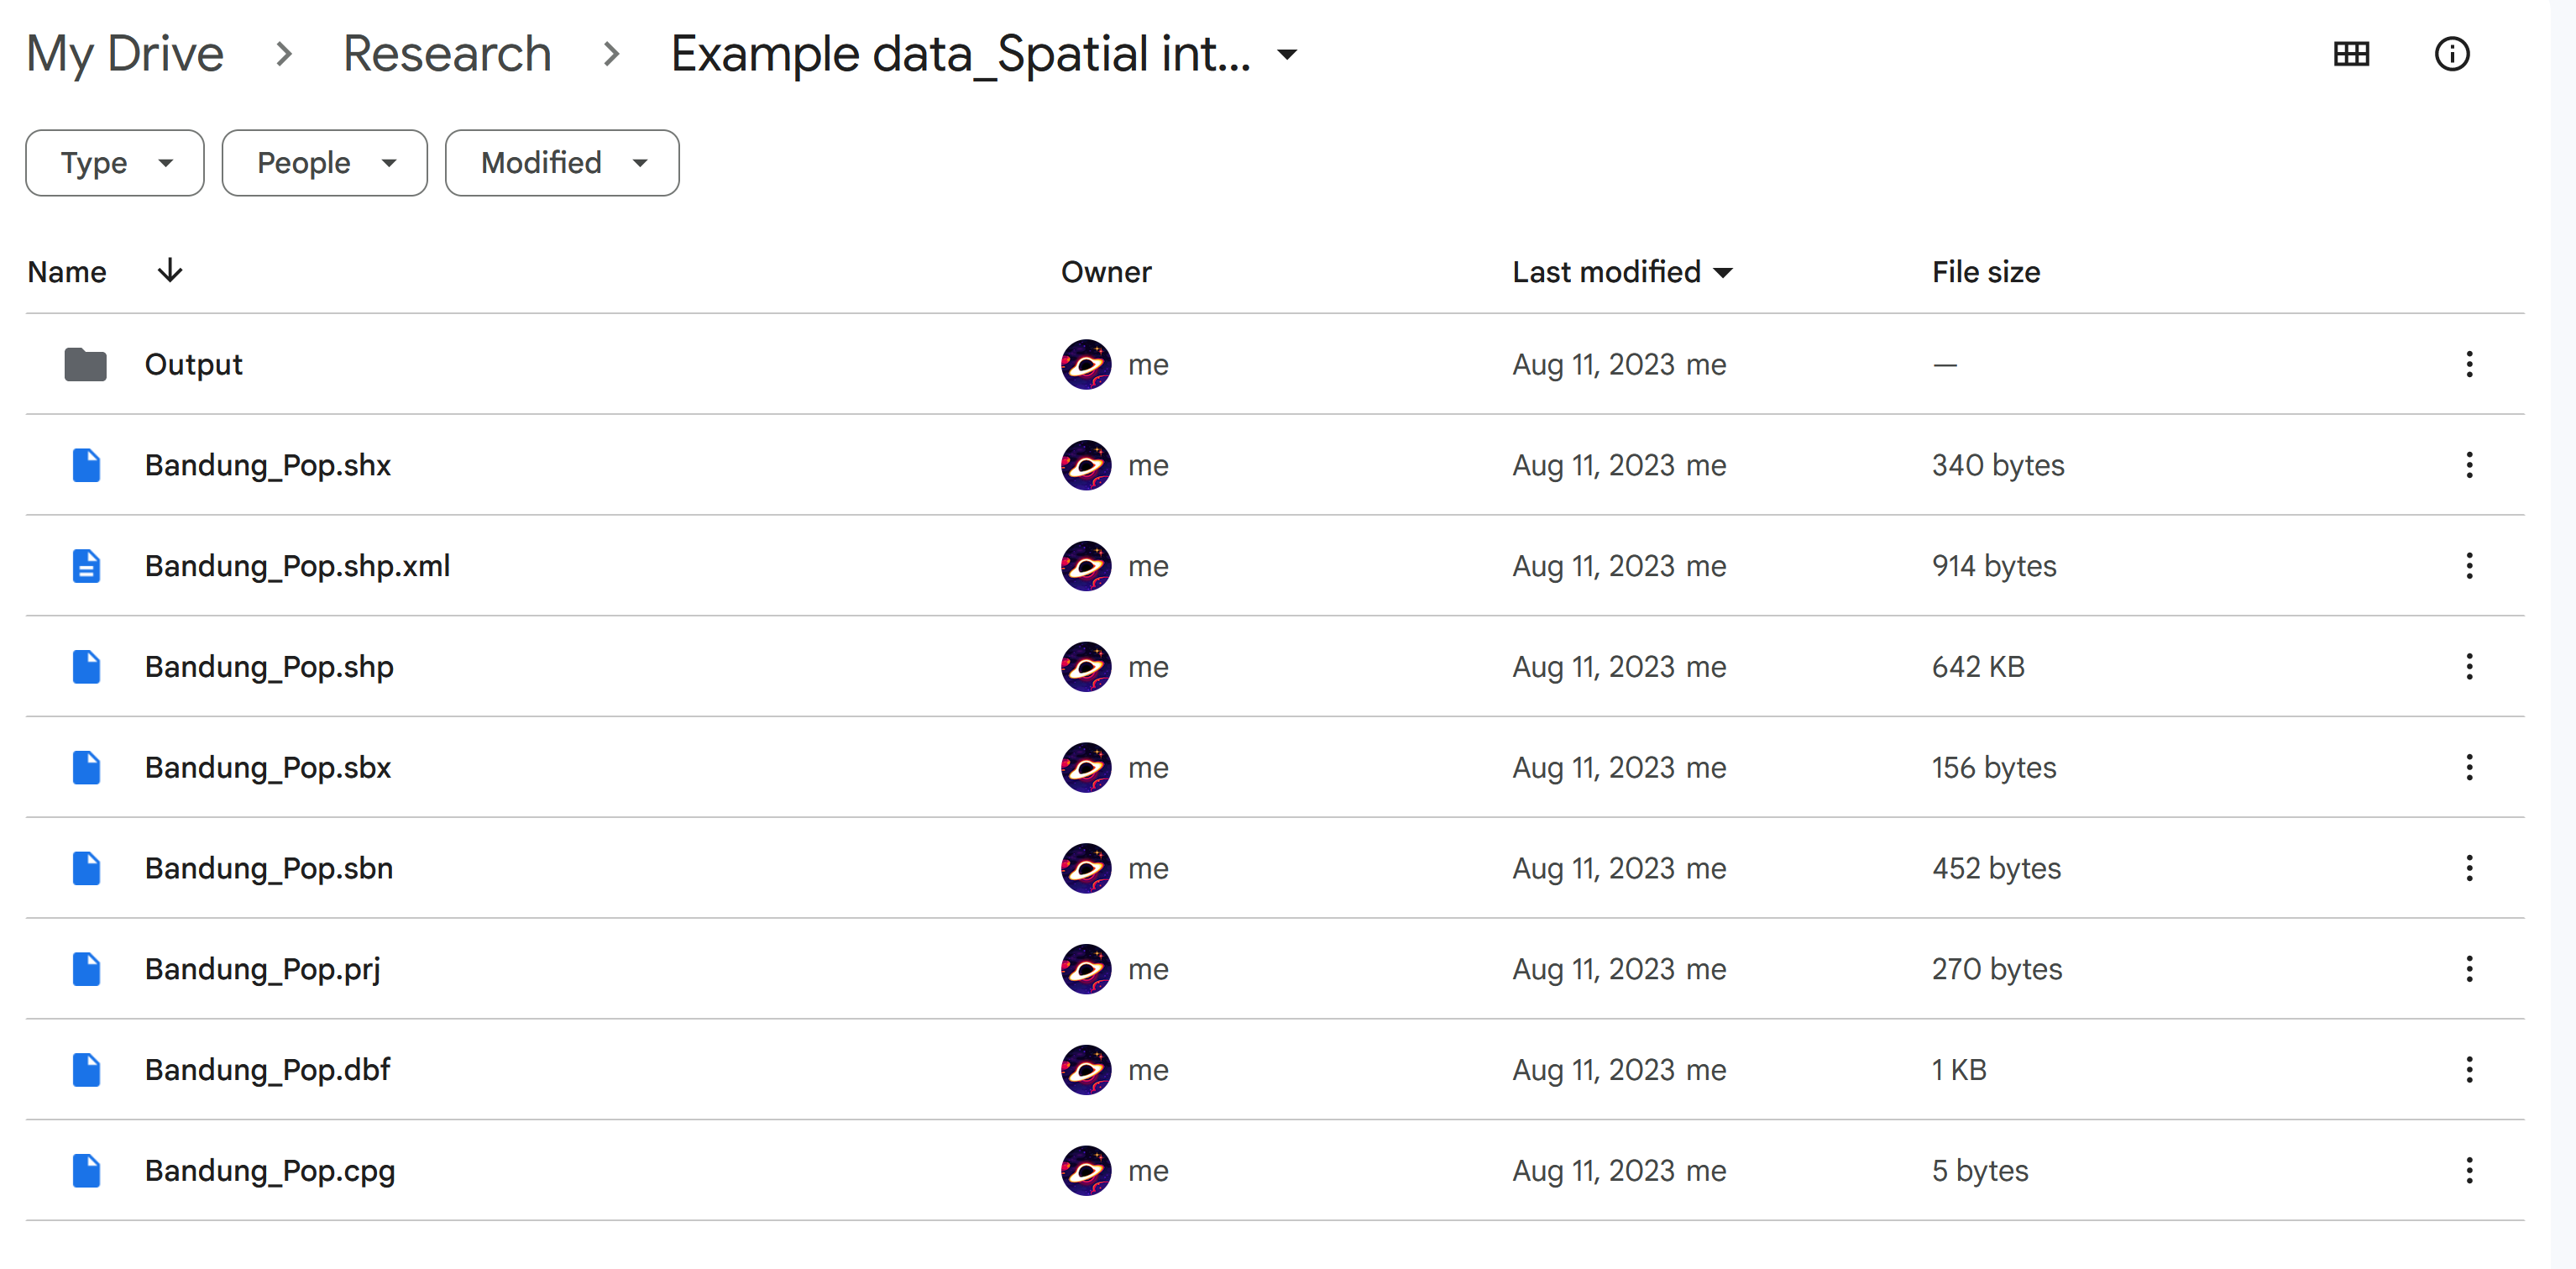

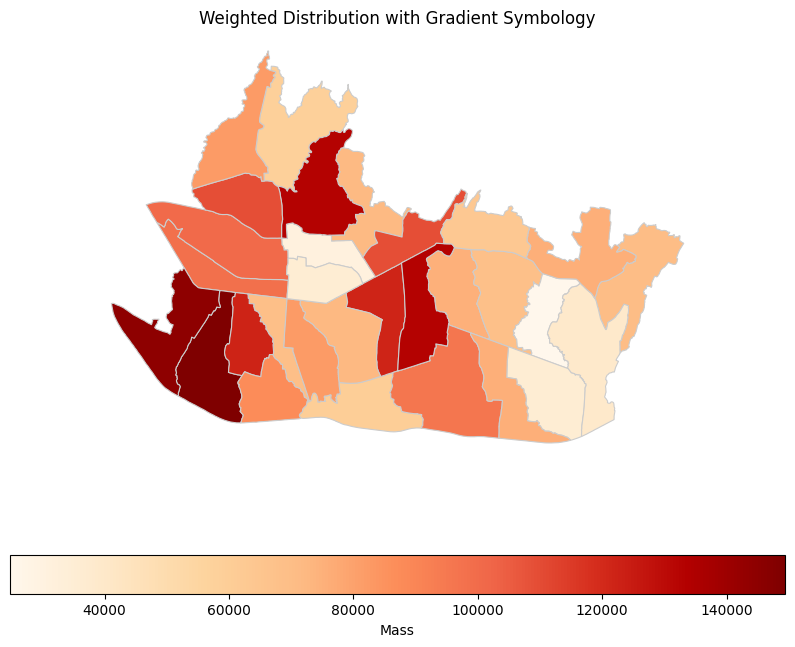

In [6]:
# 5
#---------------------visualize input shapefile value by weight


# Read the shapefile
gdf = gpd.read_file(input_path)

# Plot the data with population as gradient symbology
fig, ax = plt.subplots(figsize=(10, 8))
legend_kwds = {'label': "Mass", 'orientation': "horizontal"}
gdf.plot(column=WeightColumn, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds=legend_kwds)
ax.set_title("Weighted Distribution with Gradient Symbology")
ax.set_axis_off()

# Adjust legend size and position
leg = ax.get_legend()
if leg is not None:
    leg.set_title("Mass")
    leg.get_frame().set_linewidth(0.0)
    leg.set_bbox_to_anchor((0.5, -0.1))  # Adjust the second value to control vertical position

    for label in leg.get_texts():
        label.set_fontsize(8)  # Adjust font size

plt.show()


The value of above map is the number of population, which define mass/weight in spatial interaction mode. Make sure the there is a column/attribute that define weighted in the input file.

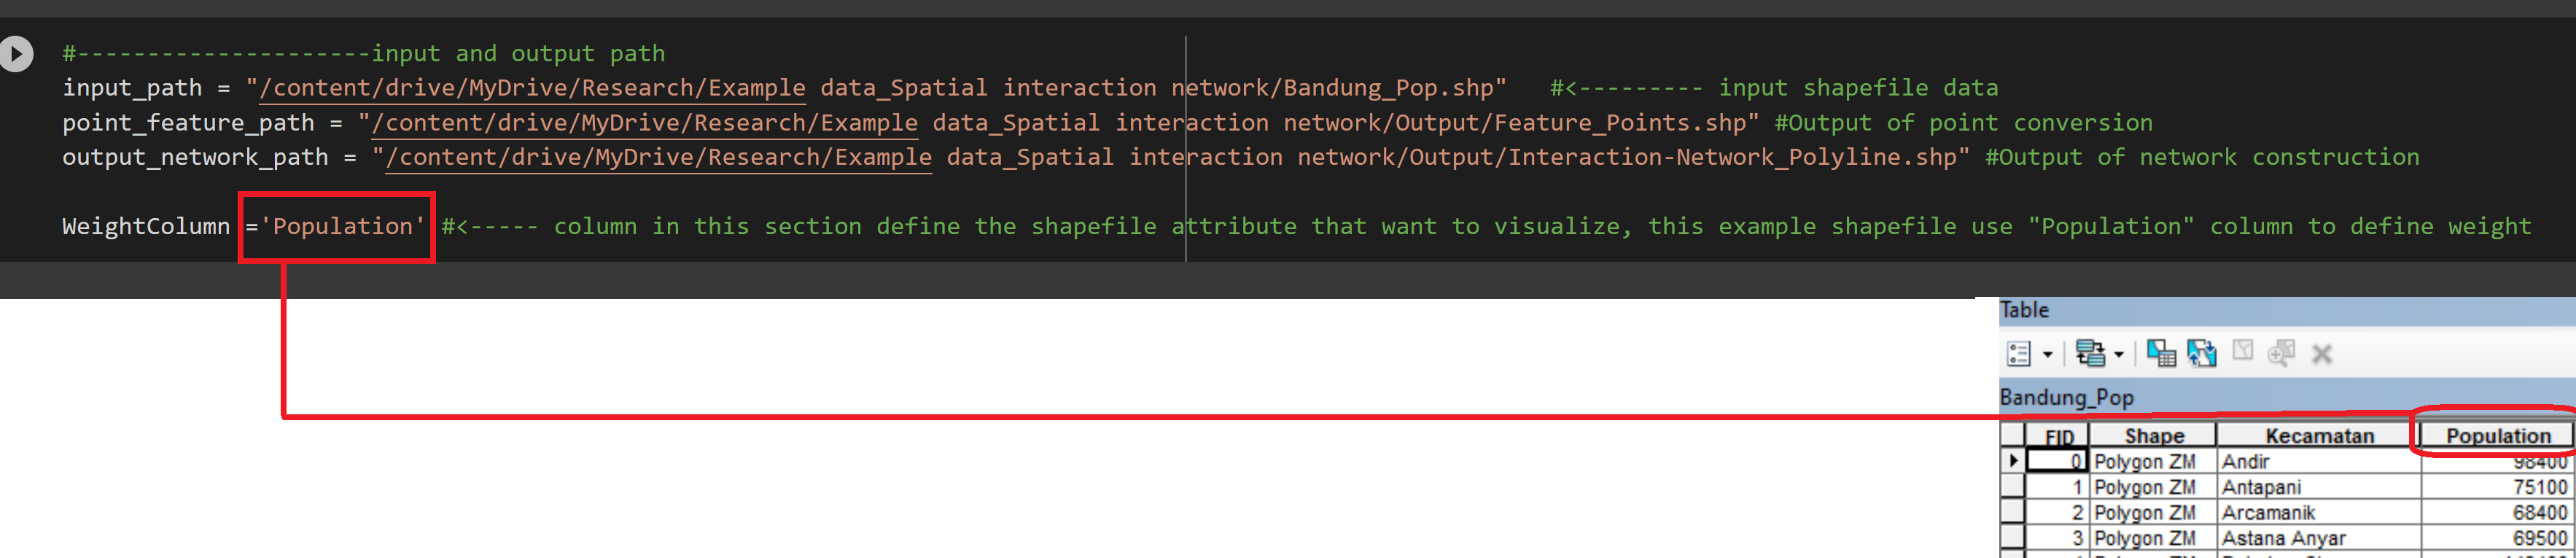

In [7]:
# 6
#------------------------feature to point


# Read the input shapefile
gdf = gpd.read_file(input_path)

# Create a GeoDataFrame for point features
point_geometry = gdf.centroid
point_gdf = gpd.GeoDataFrame(gdf[WeightColumn], geometry=point_geometry, columns=[WeightColumn])

# Save the point GeoDataFrame to a new shapefile
point_gdf.to_file(point_feature_path)


<ipython-input-7-cc26944cfde5>:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  point_geometry = gdf.centroid


In [8]:
# 7
#---------------------Constructing network

# Read the input point shapefile
point_gdf = gpd.read_file(point_feature_path)

# Create a GeoDataFrame for the polylines
lines = []
for pair in combinations(point_gdf.geometry, 2):
    lines.append({'geometry': LineString(pair)})

polyline_gdf = gpd.GeoDataFrame(lines, geometry='geometry', crs=point_gdf.crs)

# Save the polyline GeoDataFrame to a new shapefile
polyline_gdf.to_file(output_network_path)


In [9]:
# 8
#------------------Colected point value to line network


# Read the point and polyline shapefiles
point_gdf = gpd.read_file(point_feature_path)
polyline_gdf = gpd.read_file(output_network_path)

# Create empty lists to store Weight1 and Weight2 values
weight1_values = []
weight2_values = []

# Iterate through each row in the polyline GeoDataFrame
for index, row in polyline_gdf.iterrows():
    # Get the start and end coordinates of the polyline
    start_coords = row['geometry'].coords[0]
    end_coords = row['geometry'].coords[-1]

    # Find the nearest point for start and end coordinates
    start_nearest_point = point_gdf.distance(Point(start_coords)).idxmin()
    end_nearest_point = point_gdf.distance(Point(end_coords)).idxmin()

    # Get the population values of the nearest points
    weight1 = point_gdf.loc[start_nearest_point, WeightColumn]
    weight2 = point_gdf.loc[end_nearest_point, WeightColumn]

    # Append the values to the lists
    weight1_values.append(weight1)
    weight2_values.append(weight2)

# Add Weight1 and Weight2 columns to the polyline GeoDataFrame
polyline_gdf['Weight1'] = weight1_values
polyline_gdf['Weight2'] = weight2_values

# Save the modified polyline GeoDataFrame back to the shapefile
polyline_gdf.to_file(output_network_path)


<ipython-input-9-728651414f50>:20: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  start_nearest_point = point_gdf.distance(Point(start_coords)).idxmin()
<ipython-input-9-728651414f50>:21: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  end_nearest_point = point_gdf.distance(Point(end_coords)).idxmin()


In [10]:
# 9
#----------------Calculate network distance (in meters)

# Read the input polyline shapefile
polyline_gdf = gpd.read_file(output_network_path)

# Add a new column "distance" and calculate the distance of each line segment in meters using geographic coordinate system
polyline_gdf['distance'] = polyline_gdf['geometry'].to_crs("EPSG:4326").length

# Save the modified GeoDataFrame back to the shapefile
polyline_gdf.to_file(output_network_path)

<ipython-input-10-791c02088379>:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polyline_gdf['distance'] = polyline_gdf['geometry'].to_crs("EPSG:4326").length


In [11]:
# 10
#-----------------spatial interaction calculation

# Read the input polyline shapefile
polyline_gdf = gpd.read_file(output_network_path)

K = 1.0  # <--------------------- Define the constant K, K = 1 is default setting, K>1 meaning giving more important to the weight factor, while K<1 meaning giving more importang to the distance factor

# Calculate spatial interaction values for the unconstrained approach
polyline_gdf['UnCon'] = K * polyline_gdf['Weight1'] * polyline_gdf['Weight2'] * (1 / polyline_gdf['distance'])

# Save the modified GeoDataFrame back to the shapefile
polyline_gdf.to_file(output_network_path)

# Display the first few rows of the GeoDataFrame with the new column
print(polyline_gdf.head())


   FID  Weight1  Weight2  distance  \
0    0    98400    75100  0.081639   
1    1    98400    68400  0.097802   
2    2    98400    69500  0.029994   
3    3    98400   149400  0.032597   
4    4    98400    59900  0.068066   

                                            geometry         UnCon  
0  LINESTRING (107.58064 -6.91137, 107.66202 -6.9...  9.051814e+10  
1  LINESTRING (107.58064 -6.91137, 107.67817 -6.9...  6.881817e+10  
2  LINESTRING (107.58064 -6.91137, 107.60128 -6.9...  2.280053e+11  
3  LINESTRING (107.58064 -6.91137, 107.57846 -6.9...  4.509946e+11  
4  LINESTRING (107.58064 -6.91137, 107.63057 -6.9...  8.659529e+10  


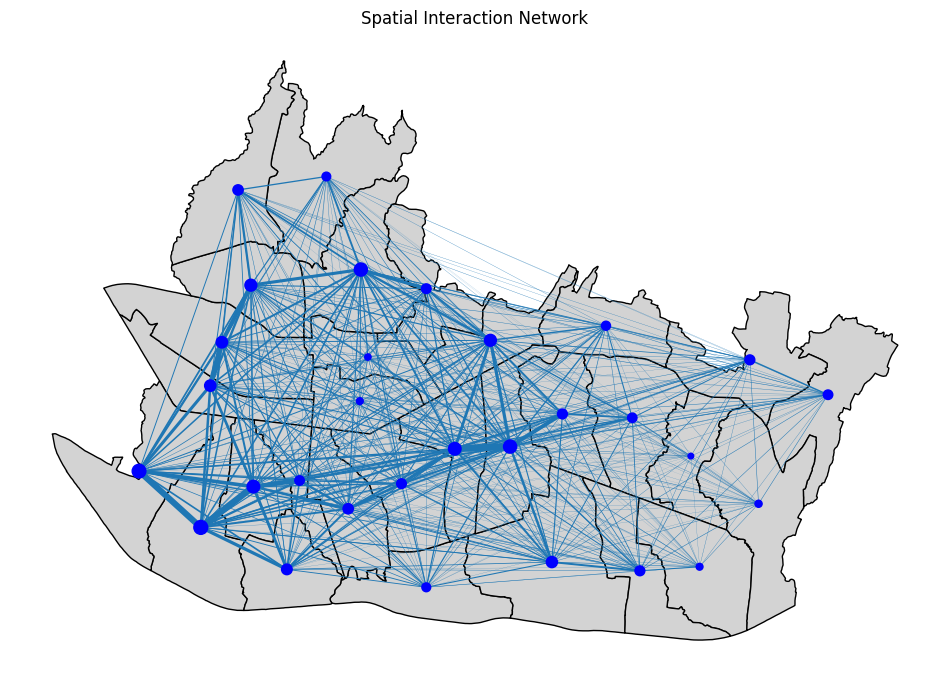

In [12]:
# 11
#------------------visualize the network interaction


# Read the shapefiles
polygon_gdf = gpd.read_file(input_path)
polyline_gdf = gpd.read_file(output_network_path)
point_gdf = gpd.read_file(point_feature_path)

# Normalize the Unconstrained values for line width
max_width = 5  # Maximum line width
polyline_gdf['UnCon'] = polyline_gdf['UnCon'] / polyline_gdf['UnCon'].max() * max_width

# Normalize the Population values for point size
max_size = 100  # Maximum point size
point_gdf['NormalizedPopulation'] = point_gdf[WeightColumn] / point_gdf[WeightColumn].max() * max_size

# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))

# Plot polygons as background
polygon_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot polylines with graduated line width based on "UnCon" values
polyline_gdf.plot(ax=ax, linewidth=polyline_gdf['UnCon'], legend=True)

# Plot points with size based on "NormalizedPopulation" values
point_gdf.plot(ax=ax, color='blue', markersize=point_gdf['NormalizedPopulation'], zorder=2)

# Set axis title
ax.set_title("Spatial Interaction Network")

# Turn off axis
ax.set_axis_off()

# Show the plot
plt.show()


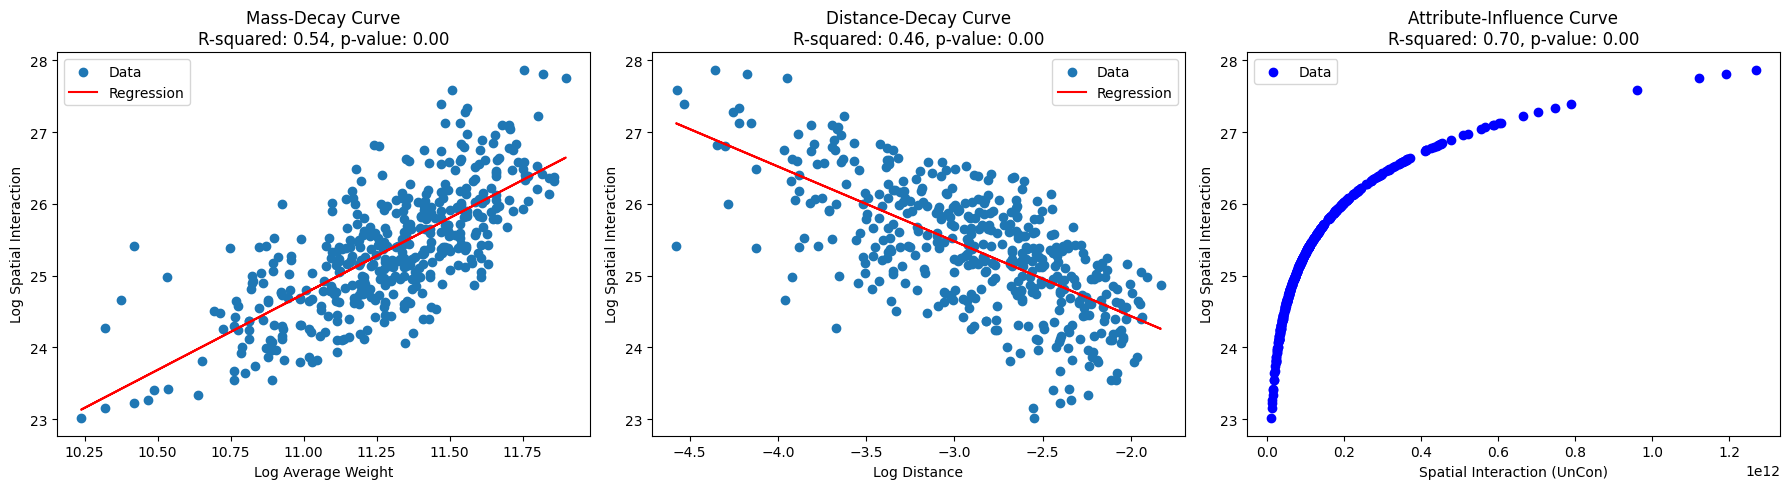

In [13]:
# 12
#---------------------------Visualize the the mass and distance decay curve


# Read the input polyline shapefile
polyline_gdf = gpd.read_file(output_network_path)

# Calculate the logarithm of the average of Weight1 and Weight2 columns
polyline_gdf['log_avg_weight'] = np.log((polyline_gdf['Weight1'] + polyline_gdf['Weight2']) / 2)

# Calculate the logarithm of distance
polyline_gdf['log_distance'] = np.log(polyline_gdf['distance'])

# Mass-Decay Regression
X_mass_decay = sm.add_constant(polyline_gdf['log_avg_weight'])
y_mass_decay = np.log(polyline_gdf['UnCon'])
model_mass_decay = sm.OLS(y_mass_decay, X_mass_decay).fit()

# Distance-Decay Regression
X_distance = sm.add_constant(polyline_gdf['log_distance'])
y_distance = np.log(polyline_gdf['UnCon'])
model_distance = sm.OLS(y_distance, X_distance).fit()

# Attribute-Influence Regression
X_attribute = sm.add_constant(polyline_gdf['UnCon'])
y_attribute = np.log(polyline_gdf['UnCon'])
model_attribute = sm.OLS(y_attribute, X_attribute).fit()

# R-squared values and p-values for Mass-Decay
r2_mass_decay = model_mass_decay.rsquared
p_value_mass_decay = model_mass_decay.pvalues[1]

# R-squared values and p-values for Distance-Decay
r2_distance = model_distance.rsquared
p_value_distance = model_distance.pvalues[1]

# R-squared values and p-values for Attribute-Influence
r2_attribute = model_attribute.rsquared
p_value_attribute = model_attribute.pvalues[1]

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Mass-Decay Curve
ax1.scatter(polyline_gdf['log_avg_weight'], y_mass_decay, label='Data')
ax1.plot(polyline_gdf['log_avg_weight'], model_mass_decay.predict(X_mass_decay), color='red', label='Regression')
ax1.set_title("Mass-Decay Curve\nR-squared: {:.2f}, p-value: {:.2f}".format(r2_mass_decay, p_value_mass_decay))
ax1.set_xlabel("Log Average Weight")
ax1.set_ylabel("Log Spatial Interaction")
ax1.legend()

# Distance-Decay Curve
ax2.scatter(polyline_gdf['log_distance'], y_distance, label='Data')
ax2.plot(polyline_gdf['log_distance'], model_distance.predict(X_distance), color='red', label='Regression')
ax2.set_title("Distance-Decay Curve\nR-squared: {:.2f}, p-value: {:.2f}".format(r2_distance, p_value_distance))
ax2.set_xlabel("Log Distance")
ax2.set_ylabel("Log Spatial Interaction")
ax2.legend()

# Attribute-Influence Curve
ax3.scatter(polyline_gdf['UnCon'], y_attribute, label='Data', color='blue')
ax3.set_title("Attribute-Influence Curve\nR-squared: {:.2f}, p-value: {:.2f}".format(r2_attribute, p_value_attribute))
ax3.set_xlabel("Spatial Interaction (UnCon)")
ax3.set_ylabel("Log Spatial Interaction")
ax3.legend()

plt.tight_layout()
plt.show()


In [14]:
# 13
# ----------------------- Display regression results
print("Mass-Decay Regression:")
print(model_mass_decay.summary())

print("\nDistance-Decay Regression:")
print(model_distance.summary())

print("\nAttribute-Influence Regression:")
print(model_attribute.summary())

Mass-Decay Regression:
                            OLS Regression Results                            
Dep. Variable:                  UnCon   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     500.5
Date:                Sat, 23 Sep 2023   Prob (F-statistic):           3.06e-74
Time:                        05:43:42   Log-Likelihood:                -385.93
No. Observations:                 435   AIC:                             775.9
Df Residuals:                     433   BIC:                             784.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.